In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from joblib import Parallel, delayed
from tqdm import tqdm


from sklearn.model_selection import KFold, TimeSeriesSplit

from gait_modulation import FeatureExtractor
from gait_modulation import LinearRegressionModel, RegressionLSTMModel
from gait_modulation.utils.utils import split_data_stratified, load_config, create_lagged_data, initialize_tf, disable_xla, save_pickle

from tensorflow.keras.callbacks import Callback,  ModelCheckpoint, TensorBoard


# Illustration of model prediction with different time lags (Random data)

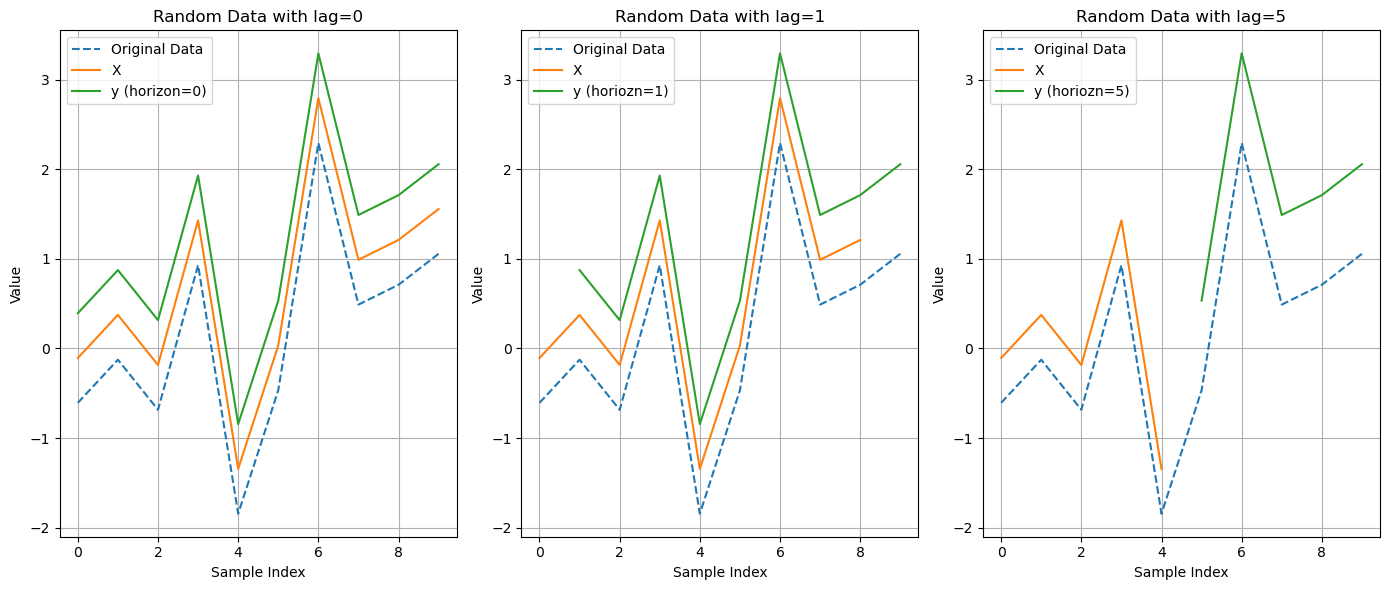

In [2]:
# Illustration of of model prediction with different time lags
# Generate random data
np.random.seed(40)
random_data = np.random.randn(10)
dt = [0, 1, 5]

fig, axs = plt.subplots(1, 3, figsize=(14, 6))

for i, d in enumerate(dt):
    axs[i].plot(random_data, '--', label="Original Data")
    if d == 0:
        axs[i].plot(np.arange(0, len(random_data)), random_data+0.5, label="X")
        axs[i].plot(np.arange(d, len(random_data)), random_data+1, label=f"y (horizon={d})")
    else:
        axs[i].plot(np.arange(0, len(random_data)-d), random_data[:-d]+0.5, label="X")
        axs[i].plot(np.arange(d, len(random_data)), random_data[d:]+1, label=f"y (horiozn={d})")
    axs[i].set_title(f"Random Data with lag={d}")
    axs[i].set_xlabel("Sample Index")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [3]:
lfp_metadata_config = load_config('gait_modulation/configs/written/lfp_metadata_config.yaml')

sfreq = lfp_metadata_config['LFP_METADATA']['lfp_sfreq']

# Load time_continuous_uniform or time_epoched data

In [4]:
data_type = 'time_epoched' # or 'time_continuous_uniform'

if data_type == 'time_continuous_uniform':
    data = np.load('processed/features/time_continuous_uniform-feat.npz')['times_uniform']
    # data = np.load('/data/orabem/processed/features/time_continuous_uniform-feat.npz')['times_uniform']
elif data_type == 'time_epoched':
    data = mne.read_epochs('processed/lfp_-3.0tmin_5gap-epo.fif').get_data(copy=False)

print(f'>>> {data_type}: {data.shape}')

Reading /Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/gait_modulation/processed/lfp_-3.0tmin_5gap-epo.fif ...
    Found the data of interest:
        t =   -3000.00 ...       0.00 ms
        0 CTF compensation matrices available
Not setting metadata
891 matching events found
No baseline correction applied
0 projection items activated
>>> time_epoched: (891, 6, 751)


# Define future horizons (in samples)

In [5]:
horizons_samples = [0, 3, 12, 25]
horizons_ms = [(samples * 1000 / sfreq) for samples in horizons_samples]
horizons_ms

[0.0, 12.0, 48.0, 100.0]

In [6]:
config_path_linear = 'gait_modulation/configs/linearRegression_config.yaml'
config_path_lstm = 'gait_modulation/configs/regression_lstm_config.yaml'

# Define a set of models to evaluate
models = {
    "linear_regression": LinearRegressionModel(config_path_linear, model_type='linear'),
    "ridge_regression": LinearRegressionModel(config_path_linear, model_type='ridge'),
    "lasso_regression": LinearRegressionModel(config_path_linear, model_type='lasso'),
    "lstm_regression": RegressionLSTMModel(config_path_lstm),
}


class CustomProgressLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # logs = logs or {}
        # print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        # print(f"\n---------------------------- Epoch {epoch+1} ----------------------------\n")
        pass
    
    def on_batch_end(self, batch, logs=None):
        # logs = logs or {}
        # loss = logs.get('loss', 0.0)
        # accuracy = logs.get('accuracy', 0.0)
        # print(f"Batch {batch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        pass
    
# Define the callbacks
tensorboard_callback = TensorBoard(log_dir='regression_logs/fit', histogram_freq=0)  # Set to 0 to disable histogram logging

checkpoint_callback = ModelCheckpoint(
    filepath='lstm_regression_best_model.h5', 
    monitor='loss', 
    save_best_only=True
)

callbacks = [
    # CustomProgressLogger(),
    # checkpoint_callback,
    # tensorboard_callback,
    # EarlyStopping(monitor='loss', patience=2, restore_best_weights=True),
    # ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-5)
]

In [7]:
# Log available devices and GPU details
# Initialize TensorFlow configuration
disable_xla()
initialize_tf()

Available devices:
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

LogicalDevice(name='/device:CPU:0', device_type='CPU')
LogicalDevice(name='/device:GPU:0', device_type='GPU')
Running on GPU
Num GPUs Available: 1

GPU 0 Details:
device_name: METAL

Logical GPUs Available: 1
Logical GPU 0: LogicalDevice(name='/device:GPU:0', device_type='GPU')
Built with CUDA: False
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is not built with CUDA.
Failed to enable memory growth for GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): Physical devices cannot be modified after being initialized

Using Metal API for Apple Silicon (if applicable).


2025-01-10 15:16:04.642461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-10 15:16:04.643044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Train and evaluate without parallelization!

In [8]:
# def train(model, X, y, split_strategy, callbacks=None):
#     """
#     Trains the model and generates predictions for each fold.

#     Args:
#         model: The model to be trained.
#         X: Input features.
#         y: Target values.
#         split_strategy: Cross-validation splitting strategy (KFold or TimeSeriesSplit).
#         callbacks: Callbacks for LSTM training (optional).

#     Returns:
#         Dictionary containing predictions and true values for each fold.
#     """
#     predictions = {}
    
#     for fold, (train_idx, test_idx) in enumerate(split_strategy.split(X), 1):
#         # Split data into training and testing sets
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]
        
#         # Train the model
#         if model.model_type == 'lstm':
#             model.fit(X_train, y_train, callbacks)
#         else:
#             model.fit(X_train, y_train)
        
#         # Predict on the test set
#         y_pred = model.predict(X_test)
        
#         # Store fold predictions
#         predictions[fold] = {'y_test': y_test, 'y_pred': y_pred}
    
#     return predictions


# def evaluate(p, model):
#     """
#     Evaluates the model's performance across all folds.

#     Args:
#         predictions: Dictionary containing predictions and true values for each fold.
#         model: The model used for training.

#     Returns:
#         Dictionary containing average and standard deviation of metrics across folds.
#     """
#     # Use provided metrics or default metrics
#     metrics = model.metrics or ['mse', 'mae', 'r2']
#     metrics_summary = {metric: [] for metric in metrics}
    
#     for fold, results in p.items():
#         y_test = results['y_test']
#         y_pred = results['y_pred']
        
#         # Compute metrics for the fold
#         evaluation_results = model.evaluate(y_test, y_pred)
#         results.update(evaluation_results) # update values in-place in the results dictionary
        
#         # Log metrics for the fold
#         metrics_str = ", ".join(
#             f"{metric.upper()}: {evaluation_results[metric]:.4f}"
#             for metric in metrics
#         )
#         print(f"Fold {fold} | {metrics_str}")
        
#         # Append fold results to summary
#         for metric in metrics:
#             metrics_summary[metric].append(evaluation_results[metric])
    
#     # Compute average and std for metrics
#     avg_metrics = {
#         metric_name: {'avg': np.mean(values), 'std': np.std(values)}
#         for metric_name, values in metrics_summary.items()
#     }
    
#     for metric_name, stats in avg_metrics.items():
#         print(f"{metric_name.upper()} - Avg: {stats['avg']:.4f}, Std: {stats['std']:.4f}")
    
#     return avg_metrics


# # Main Workflow
# def train_and_evaluate(horizons_samples, models, split_strategy, data, data_type, sfreq, callbacks=None):
#     """
#     Combines training and evaluation for all models and horizons.

#     Args:
#         horizons_samples: List of horizons (future samples to predict).
#         models: Dictionary of models.
#         split_strategy: Instance of KFold or TimeSeriesSplit.
#         data: LFP data.
#         sfreq: Sampling frequency.
#         callbacks: Callbacks for LSTM training (optional).

#     Returns:
#         Predictions and metrics summaries for all horizons and models.
#     """
#     predictions = {}
#     folds_avg_metrics = {}

#     for horizon in horizons_samples:
#         print(f"\n### Predicting {horizon} samples ({horizon / sfreq * 1000} ms) into the future ###\n")
#         predictions[horizon] = {}
#         folds_avg_metrics[horizon] = {}

#         for model_name, model in models.items():
#             print(f"### Training {model_name} model ###\n")

#             # Reshape data based on model requirements
#             reshaped_data = (
#                 data.transpose(0, 2, 1)[:, 0:30, :]
#                 if model_name == 'lstm_regression'
#                 else FeatureExtractor.reshape_lfp_data(data, mode="flat_time")
#             )

#             X, y = create_lagged_data(reshaped_data, horizon)

#             # Train the model and get predictions
#             model_predictions = train(model, X, y, split_strategy, callbacks)
#             predictions[horizon][model_name] = model_predictions

#             # Evaluate the model
#             avg_metrics = evaluate(model_predictions, model)
#             folds_avg_metrics[horizon][model_name] = avg_metrics

#         print("\n" + "-" * 70)

#     return predictions, folds_avg_metrics


# n_splits = 5
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# tscv = TimeSeriesSplit(n_splits=n_splits)

# # Train using KFold
# predictions_kf, folds_avg_metrics_kf = train_and_evaluate(
#     horizons_samples, models, kf, data, data_type, sfreq, callbacks
# )

# # # Train using TimeSeriesSplit
# predictions_tscv, folds_avg_metrics_tscv = train_and_evaluate(
#     horizons_samples, models, tscv, data, data_type, sfreq, callbacks, 
# )

## # Parallel Training and Evaluation

In [9]:
# Parallel Training and Evaluation
def train_and_evaluate_parallel(horizons_samples, models, split_strategy, data, data_type, sfreq, callbacks=None, n_jobs=-1):
    predictions = {}
    folds_avg_metrics = {}

    for horizon in horizons_samples:
        print(f"\n### Predicting {horizon} samples ({horizon / sfreq * 1000} ms) into the future ###\n")
        predictions[horizon] = {}
        folds_avg_metrics[horizon] = {}

        for model_name, model in models.items():
            print(f"### Training {model_name} model ###\n")

            # Reshape data based on model requirements
            reshaped_data = (
                data.transpose(0, 2, 1)[:, 0:30, :]
                if model_name == 'lstm_regression'
                else FeatureExtractor.reshape_lfp_data(data, mode="flat_time")
            )

            X, y = create_lagged_data(reshaped_data, horizon)

            # Use Parallel to train and evaluate the model in parallel for each fold
            predictions_for_fold = Parallel(n_jobs)(
                delayed(model.train)(X, y, train_idx, test_idx, callbacks)
                for train_idx, test_idx in split_strategy.split(X)
            )
            

            
            # Use Parallel to evaluate the model's performance in parallel for each fold
            metrics_for_fold = []
            metrics_for_fold.extend(Parallel(n_jobs)(
                delayed(model.evaluate)(results, fold)
                for fold, results in enumerate(predictions_for_fold, 1)
            ))
            
            predictions[horizon][model_name] = {i+1: result for i, result in enumerate(metrics_for_fold)}
            
            metrics = model.metrics or ['mse', 'mae', 'r2']
            
            avg_metrics = {
                metric_name: {'avg': np.mean([fold[metric_name] for fold in             metrics_for_fold]),
                              'std': np.std([fold[metric_name] for fold in metrics_for_fold])}
                for metric_name in model.metrics or ['mse', 'mae', 'r2']
            }

            folds_avg_metrics[horizon][model_name] = avg_metrics
            
            for metric_name, stats in avg_metrics.items():
                print(f"{metric_name.upper()} - Avg: {stats['avg']:.4f}, Std: {stats['std']:.4f}")

        print("\n" + "-" * 70)

    return predictions, folds_avg_metrics

In [10]:
n_jobs = -1
max_jobs = os.cpu_count() if n_jobs == -1 else min(n_jobs, os.cpu_count())
print(f"Total number of CPUs: {os.cpu_count()}")

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
tscv = TimeSeriesSplit(n_splits=n_splits)

# Train using KFold (in parallel)
predictions_kf, folds_avg_metrics_kf = train_and_evaluate_parallel(
    horizons_samples, models, kf, data, data_type, sfreq, callbacks, n_jobs
)

# Train using TimeSeriesSplit (in parallel)
predictions_tscv, folds_avg_metrics_tscv = train_and_evaluate_parallel(
    horizons_samples, models, tscv, data, data_type, sfreq, callbacks, n_jobs
)

Total number of CPUs: 8

### Predicting 0 samples (0.0 ms) into the future ###

### Training linear_regression model ###

Fold 2 | MSE: 0.4195, MAE: 0.4661, R2: 0.9900
Fold 3 | MSE: 0.4195, MAE: 0.4657, R2: 0.9900
Fold 4 | MSE: 0.4181, MAE: 0.4646, R2: 0.9900
Fold 5 | MSE: 0.4208, MAE: 0.4659, R2: 0.9900
Fold 1 | MSE: 0.4200, MAE: 0.4656, R2: 0.9900
MSE - Avg: 0.4196, Std: 0.0009
MAE - Avg: 0.4656, Std: 0.0005
R2 - Avg: 0.9900, Std: 0.0000
### Training ridge_regression model ###

Fold 1 | MSE: 0.4200, MAE: 0.4656, R2: 0.9900
Fold 2 | MSE: 0.4195, MAE: 0.4661, R2: 0.9900
Fold 3 | MSE: 0.4195, MAE: 0.4657, R2: 0.9900
Fold 4 | MSE: 0.4181, MAE: 0.4646, R2: 0.9900
Fold 5 | MSE: 0.4208, MAE: 0.4659, R2: 0.9900
MSE - Avg: 0.4196, Std: 0.0009
MAE - Avg: 0.4656, Std: 0.0005
R2 - Avg: 0.9900, Std: 0.0000
### Training lasso_regression model ###

Fold 1 | MSE: 0.4200, MAE: 0.4656, R2: 0.9900
Fold 2 | MSE: 0.4195, MAE: 0.4661, R2: 0.9900
Fold 3 | MSE: 0.4195, MAE: 0.4657, R2: 0.9900
Fold 5 | MSE: 

# Save prediction along with evaluation results

In [11]:
eval_results_dir = os.path.join('results', 'pickles', 'regression', data_type, 'eval')
os.makedirs(eval_results_dir, exist_ok=True)

# Save the results as pickle
save_pickle(predictions_kf, os.path.join(eval_results_dir, 'predictions_kf.pkl'))
save_pickle(folds_avg_metrics_kf, os.path.join(eval_results_dir, 'folds_avg_metrics_kf.pkl'))
save_pickle(predictions_tscv, os.path.join(eval_results_dir, 'predictions_tscv.pkl'))
save_pickle(folds_avg_metrics_tscv, os.path.join(eval_results_dir, 'folds_avg_metrics_tscv.pkl'))

## Testing

In [12]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()

h = 0
stored_mse = []
tf_mean = []
manual_mean_mse = []
selected_moodel = 'lstm_regression'
print(f"Model: {selected_moodel} - Horizon: {horizons_samples[h]} samples ({horizons_ms[h]} ms)")
for i in range(1, n_splits+1):
    t = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_test']
    p = predictions_kf[horizons_samples[h]][selected_moodel][i]['y_pred']
    print(t.shape, p.shape)
    
    m.reset_state()
    m.update_state(t, p)
    
    manual_mse = np.mean((t - p) ** 2)
    
    tf_mean.append(m.result().numpy())
    manual_mean_mse.append(manual_mse)
    stored_mse.append(predictions_kf[horizons_samples[h]][selected_moodel][i]['mse'])
    
    print(f"stored - Fold {i} - {predictions_kf[horizons_samples[h]][selected_moodel][i]['mse']}")
    print(f"tf     - Fold {i} - {m.result().numpy()}")
    print(f"manual - Fold {i} - {manual_mse}")
    print("")

print("--")
print(f"Mean: {np.mean(stored_mse)}")
print(f"Mean: {np.mean(tf_mean)}")
print(f"Mean: {np.mean(manual_mean_mse)}")
# t.shape
# list(models.keys())

Model: lstm_regression - Horizon: 0 samples (0.0 ms)
(179, 30, 6) (179, 30, 6)
stored - Fold 1 - 26.387871416210665
tf     - Fold 1 - 26.38787269592285
manual - Fold 1 - 26.387871416210665

(178, 30, 6) (178, 30, 6)
stored - Fold 2 - 30.227955557338728
tf     - Fold 2 - 30.227954864501953
manual - Fold 2 - 30.227955557338728

(178, 30, 6) (178, 30, 6)
stored - Fold 3 - 75.78229126561057
tf     - Fold 3 - 75.78229522705078
manual - Fold 3 - 75.78229126561057

(178, 30, 6) (178, 30, 6)
stored - Fold 4 - 48.459684502805366
tf     - Fold 4 - 48.459686279296875
manual - Fold 4 - 48.459684502805366

(178, 30, 6) (178, 30, 6)
stored - Fold 5 - 41.29469750717213
tf     - Fold 5 - 41.29469680786133
manual - Fold 5 - 41.29469750717213

--
Mean: 44.430500049827494
Mean: 44.430503845214844
Mean: 44.430500049827494


# Plot evaluation metrics for both KFold and TimeSeriesSplit

In [13]:
figures_path = os.path.join('results', 'figures', 'regression', data_type, 'eval')
os.makedirs(figures_path, exist_ok=True)

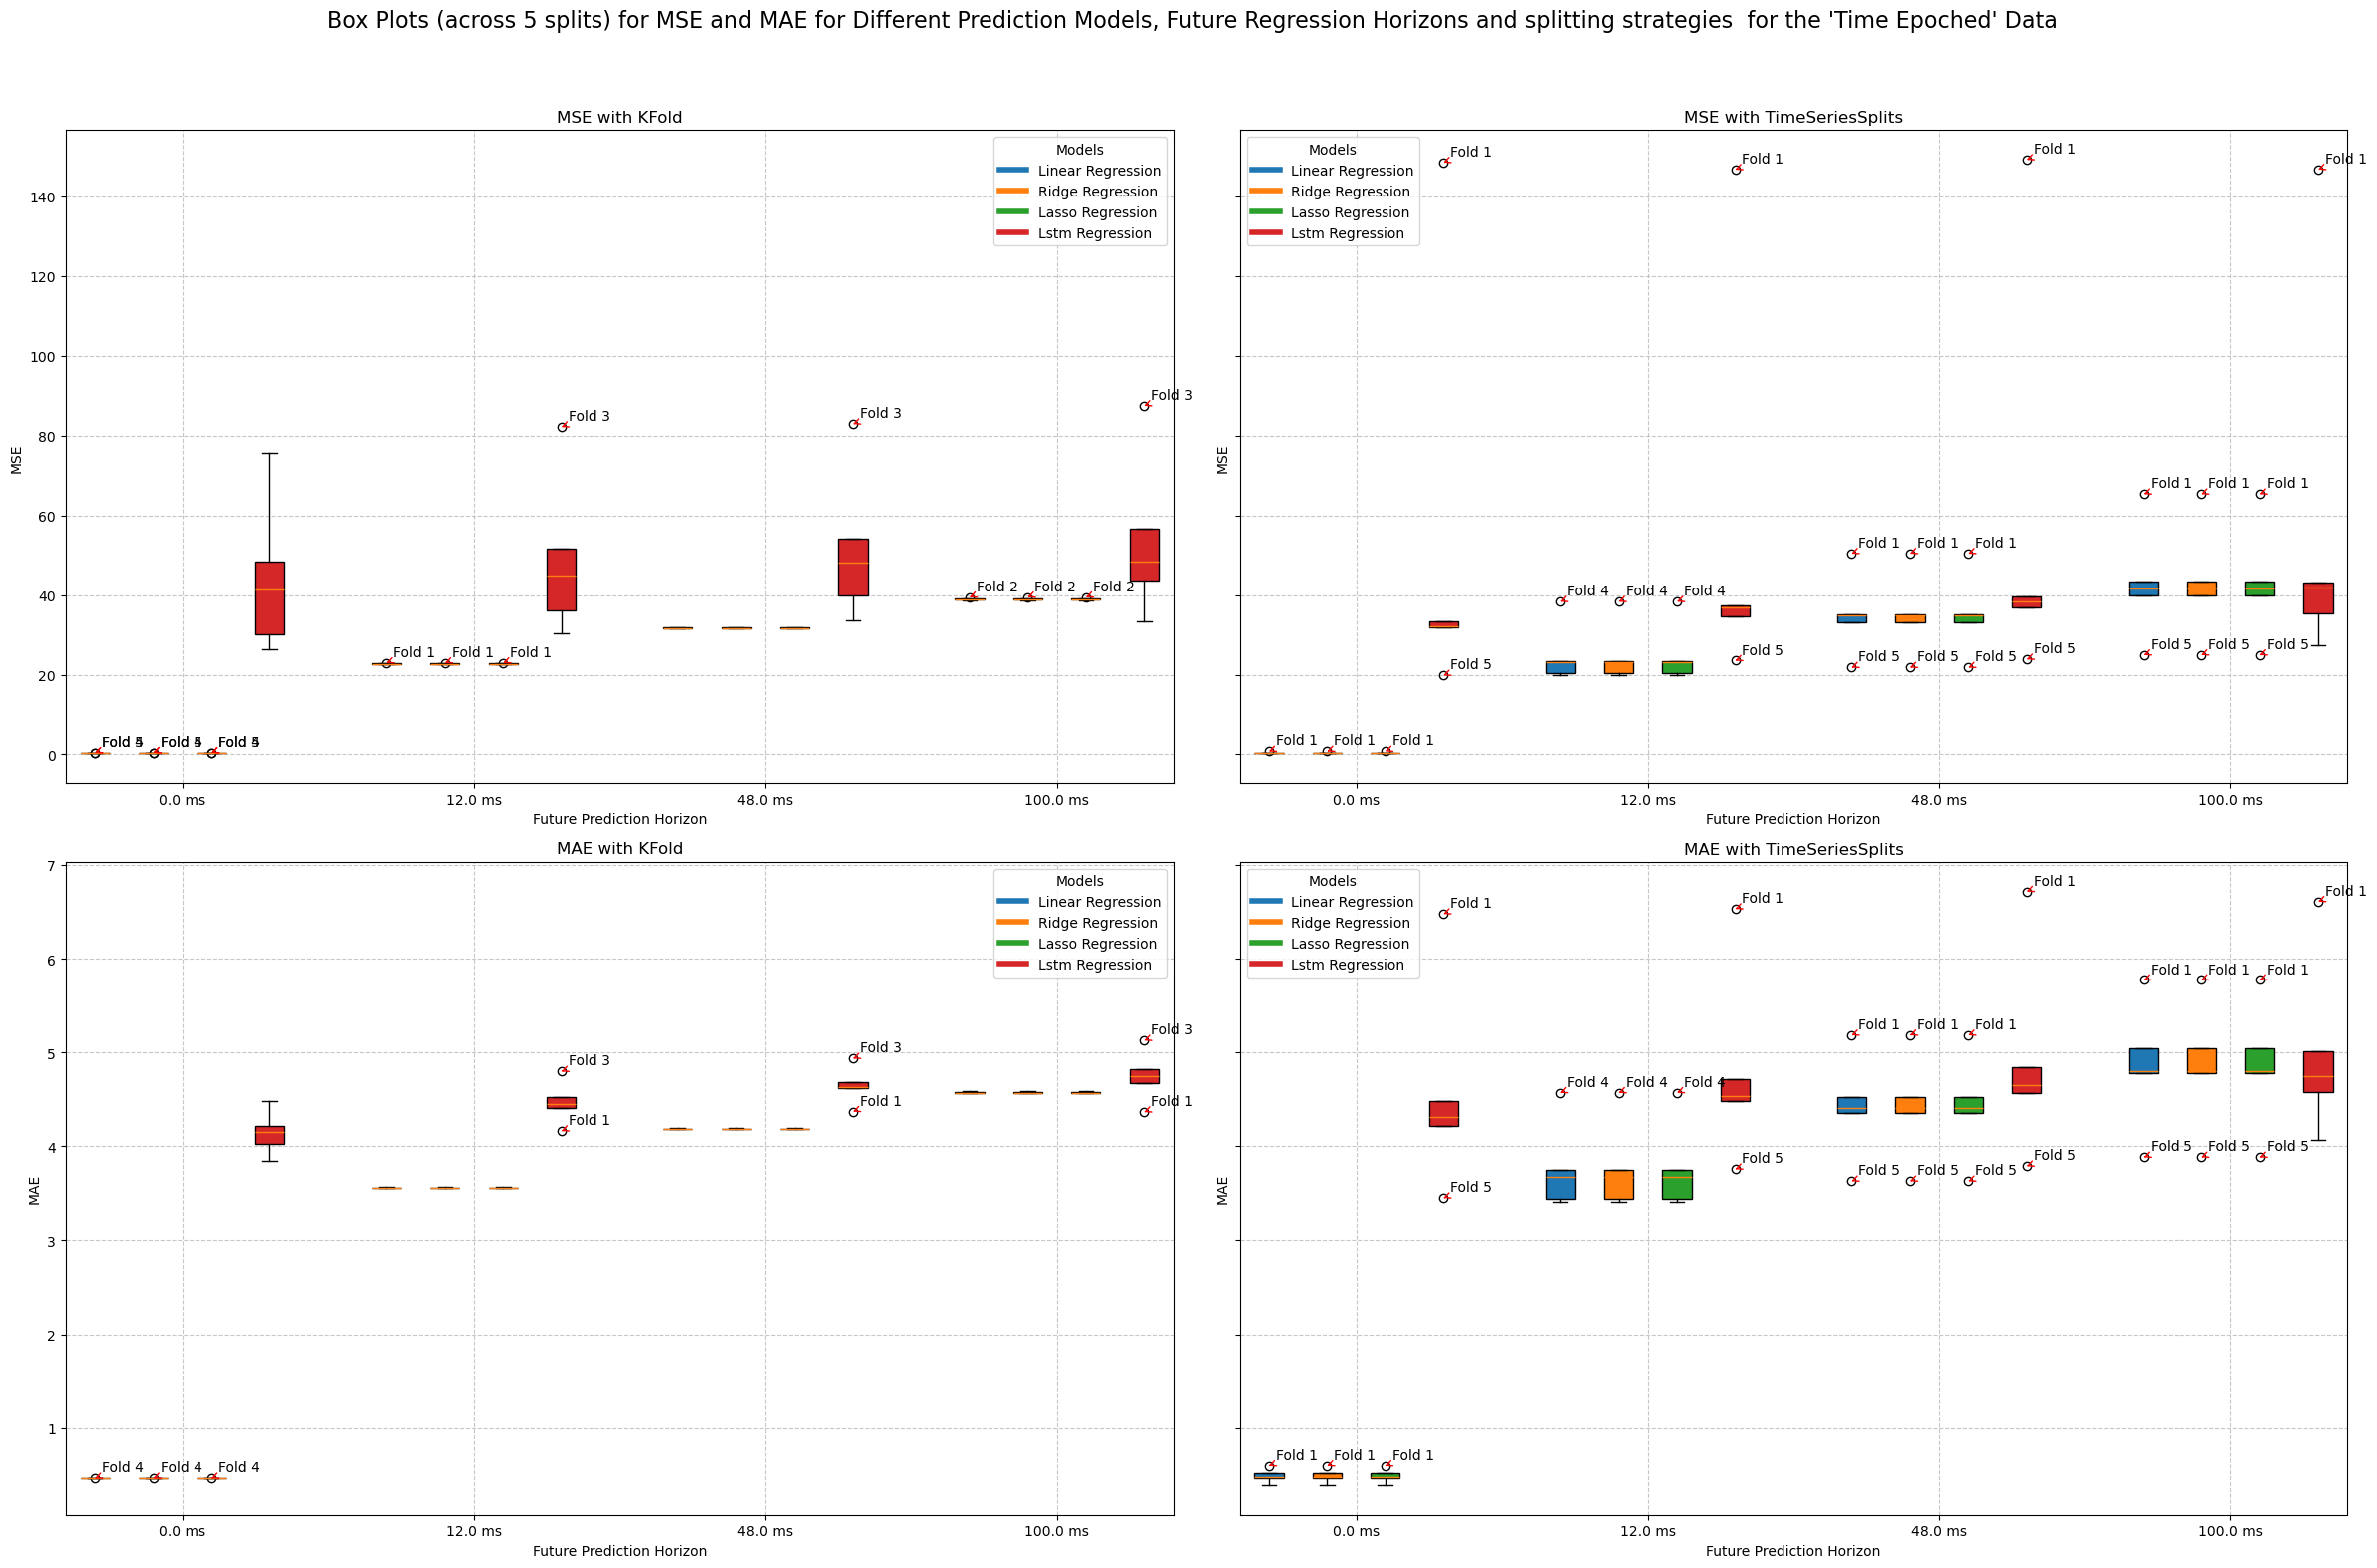

In [14]:
def prepare_box_data_and_positions(predictions, horizons_samples, models, metric, n_splits):
    """
    Prepare data and positions for box plots.
    """
    box_data = []
    positions = []
    for i, horizon_samples in enumerate(horizons_samples):
        for j, model in enumerate(models):
            data = [predictions[horizon_samples][model][fold][metric] for fold in range(1, n_splits + 1)]
            box_data.append(data)
            positions.append(i * (len(models) + 1) + j)
    return box_data, positions


def create_box_plot(ax, data, positions, title, xlabel, ylabel, colors, horizons_samples, models):
    """
    Create a box plot with custom settings.
    """
    box = ax.boxplot(data, positions=positions, patch_artist=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.7)

    # Apply colors
    for patch, color in zip(box["boxes"], colors * len(horizons_samples)):
        patch.set_facecolor(color)

    # Set x-axis ticks and labels
    unique_labels = [f"{horizon_ms} ms" for horizon_ms in horizons_ms]
    ax.set_xticks([i * (len(models) + 1) + (len(models) - 1) / 2 for i in range(len(horizons_samples))])
    ax.set_xticklabels(unique_labels)
    return box


def annotate_outliers(ax, box, positions, predictions, horizons_samples, models, metric, n_splits):
    """
    Annotate outliers on the box plot with fold indices.
    """
    for i, horizon_samples in enumerate(horizons_samples):
        for j, model in enumerate(models):
            fold_data = [predictions[horizon_samples][model][fold][metric] for fold in range(1, n_splits + 1)]
            for k, value in enumerate(fold_data):
                if value in box["fliers"][i * len(models) + j].get_ydata():
                    ax.annotate(
                        f"Fold {k + 1}",
                        xy=(positions[i * len(models) + j], value),
                        xytext=(5, 5),
                        textcoords="offset points",
                        arrowprops=dict(arrowstyle="->", color="red"),
                    )
                    
# Prepare data and positions
box_data_kf_mse, positions_kf_mse = prepare_box_data_and_positions(
    predictions_kf, horizons_samples, models, "mse", n_splits
)
box_data_tscv_mse, positions_tscv_mse = prepare_box_data_and_positions(
    predictions_tscv, horizons_samples, models, "mse", n_splits
)
box_data_kf_mae, positions_kf_mae = prepare_box_data_and_positions(
    predictions_kf, horizons_samples, models, "mae", n_splits
)
box_data_tscv_mae, positions_tscv_mae = prepare_box_data_and_positions(
    predictions_tscv, horizons_samples, models, "mae", n_splits
)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey="row")

# Titles and labels
titles = [
    "MSE with KFold",
    "MSE with TimeSeriesSplits",
    "MAE with KFold",
    "MAE with TimeSeriesSplits",
]
ylabels = ["MSE", "MSE", "MAE", "MAE"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"] 

# Create box plots
boxes = [
    create_box_plot(axs[0, 0], box_data_kf_mse, positions_kf_mse, titles[0], "Future Prediction Horizon", ylabels[0], colors, horizons_samples, models),
    create_box_plot(axs[0, 1], box_data_tscv_mse, positions_tscv_mse, titles[1], "Future Prediction Horizon", ylabels[1], colors, horizons_samples, models),
    create_box_plot(axs[1, 0], box_data_kf_mae, positions_kf_mae, titles[2], "Future Prediction Horizon", ylabels[2], colors, horizons_samples, models),
    create_box_plot(axs[1, 1], box_data_tscv_mae, positions_tscv_mae, titles[3], "Future Prediction Horizon", ylabels[3], colors, horizons_samples, models),
]

# Annotate outliers
annotate_outliers(axs[0, 0], boxes[0], positions_kf_mse, predictions_kf, horizons_samples, models, "mse", n_splits)
annotate_outliers(axs[0, 1], boxes[1], positions_tscv_mse, predictions_tscv, horizons_samples, models, "mse", n_splits)
annotate_outliers(axs[1, 0], boxes[2], positions_kf_mae, predictions_kf, horizons_samples, models, "mae", n_splits)
annotate_outliers(axs[1, 1], boxes[3], positions_tscv_mae, predictions_tscv, horizons_samples, models, "mae", n_splits)

# Add legends
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
for ax in axs.ravel():
    ax.legend(handles,
              [elem.replace('_', ' ').title() for elem in list(models.keys())], title="Models")

fig.suptitle(f"Box Plots (across {n_splits} splits) for MSE and MAE for Different Prediction Models, Future Regression Horizons and splitting strategies  for the '{data_type.replace('_', ' ').title()}' Data", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(figures_path, f'boxplot_eval.png'))
plt.show()
plt.close()

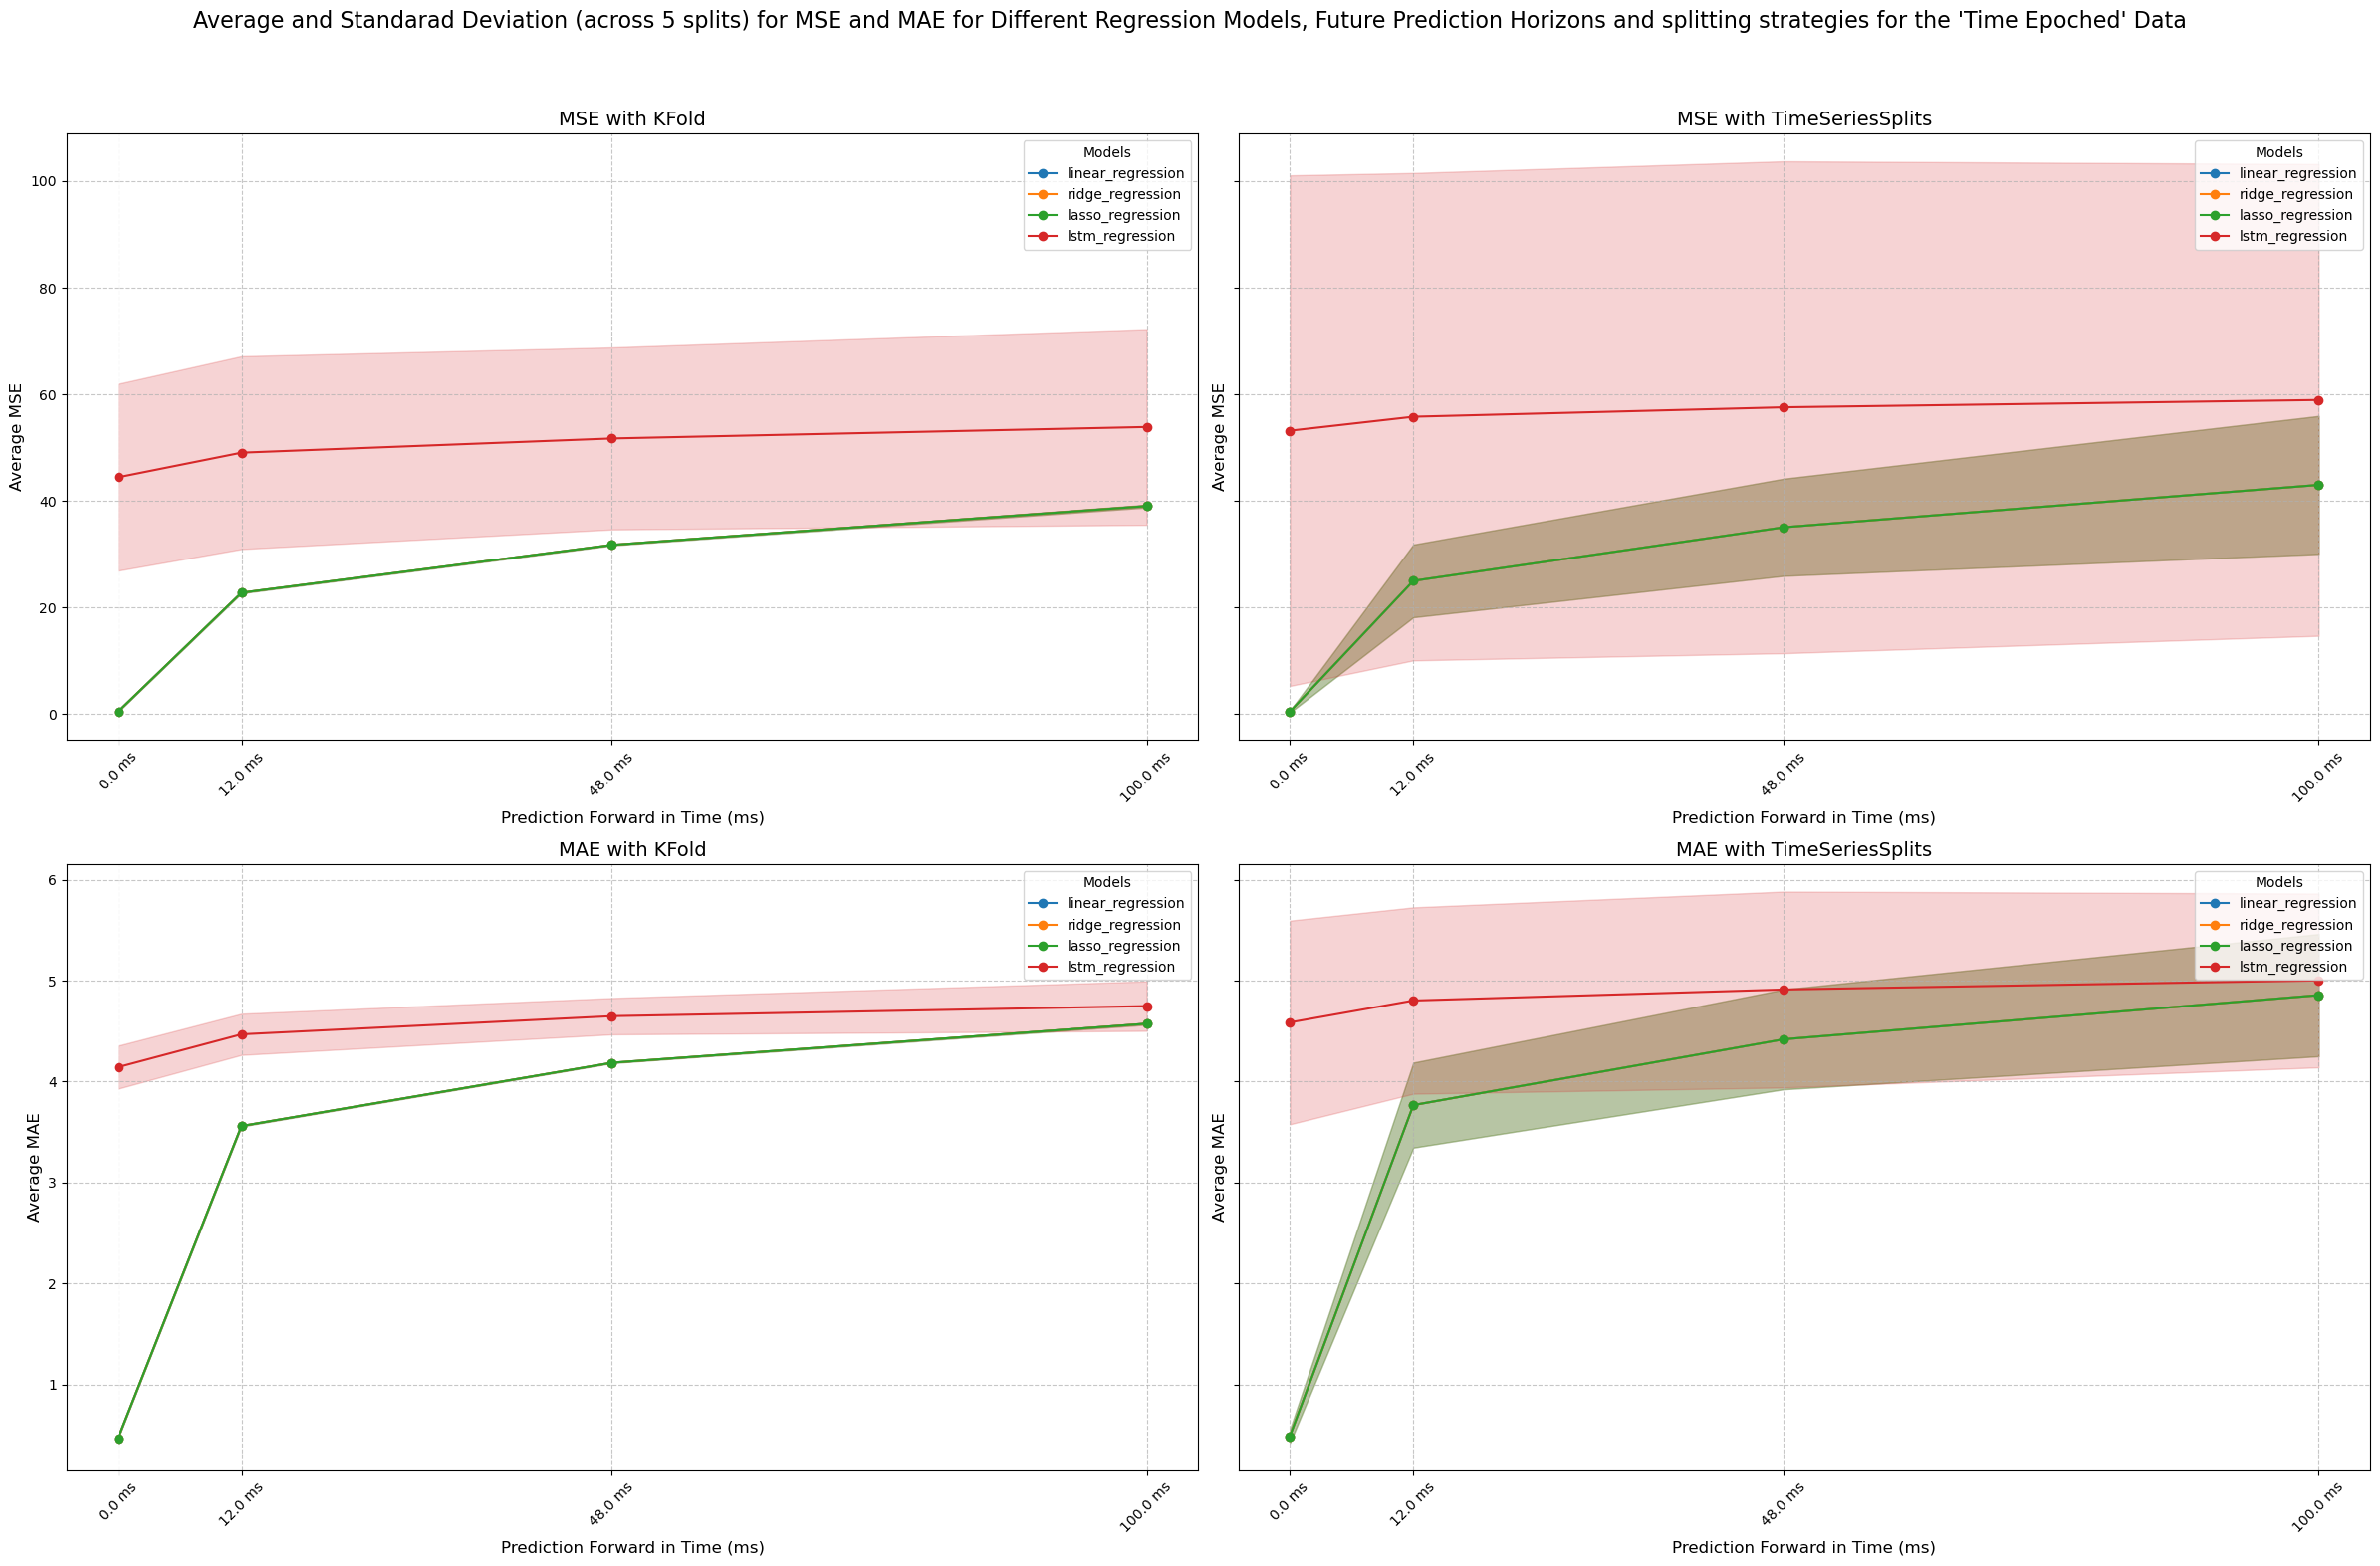

In [15]:
# Function to plot metrics for a specific axis
def plot_metrics(ax, horizons, folds_avg_metrics, metric, title):
    for idx, model in enumerate(models):
        # Prepare average and standard deviation for the given metric
        mean_metric = [folds_avg_metrics[horizon][model][metric]['avg'] for horizon in horizons]
        std_metric = [folds_avg_metrics[horizon][model][metric]['std'] for horizon in horizons]

        # Plot line and fill variance
        ax.plot(horizons_ms, mean_metric, marker='o', label=model, color=colors[idx])
        ax.fill_between(horizons_ms, 
                        np.array(mean_metric) - np.array(std_metric), 
                        np.array(mean_metric) + np.array(std_metric), 
                        color=colors[idx], alpha=0.2)

    # Customize the subplot
    ax.set_xlabel('Prediction Forward in Time (ms)', fontsize=12)
    ax.set_ylabel(f'Average {metric.upper()}', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(title="Models", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# Line plot for average metrics with variance
fig, axs = plt.subplots(2, 2, figsize=(24, 16), sharey='row')  # 2 rows, 2 columns for MSE and MAE

    
# Plot MSE for KFold
plot_metrics(axs[0, 0], horizons_samples, folds_avg_metrics_kf, 'mse', 
             "MSE with KFold",)

# Plot MSE for TimeSeriesSplit
plot_metrics(axs[0, 1], horizons_samples, folds_avg_metrics_tscv, 'mse', 
             "MSE with TimeSeriesSplits",)

# Plot MAE for KFold
plot_metrics(axs[1, 0], horizons_samples, folds_avg_metrics_kf, 'mae', 
             "MAE with KFold",)

# Plot MAE for TimeSeriesSplit
plot_metrics(axs[1, 1], horizons_samples, folds_avg_metrics_tscv, 'mae', 
             "MAE with TimeSeriesSplits",)

# Set x-axis ticks and labels for all subplots
for ax in axs.flat:
    ax.set_xticks(horizons_ms)
    ax.set_xticklabels([f'{ms} ms' for ms in horizons_ms], rotation=45)

fig.suptitle(f"Average and Standarad Deviation (across {n_splits} splits) for MSE and MAE for Different Regression Models, Future Prediction Horizons and splitting strategies for the '{data_type.replace('_', ' ').title()}' Data", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 


plt.savefig(os.path.join(figures_path, f'line_eval.png'))
plt.show()
plt.close()

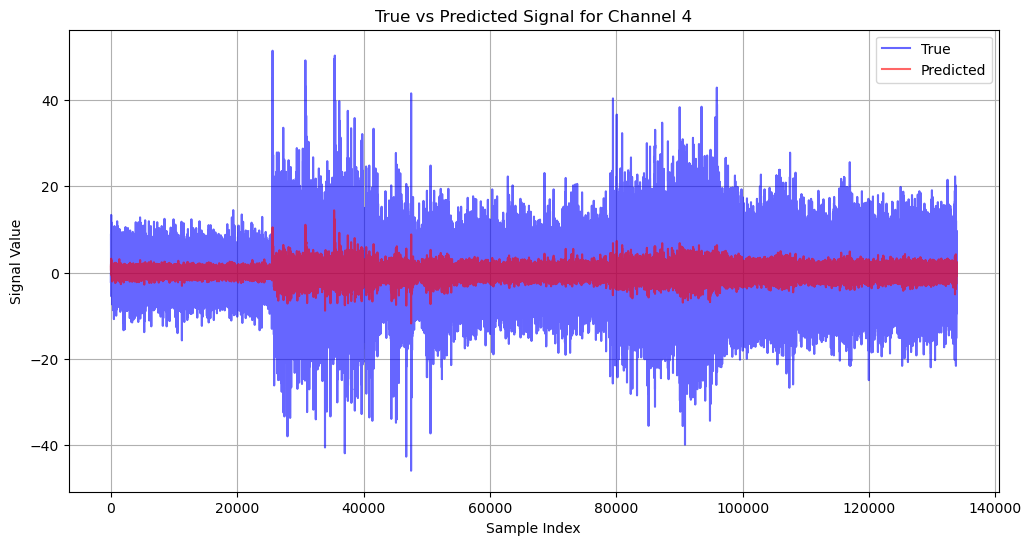

In [16]:
# Testing
t = predictions_kf[horizons_samples[3]]['linear_regression'][1]['y_test']
p = predictions_kf[horizons_samples[3]]['linear_regression'][1]['y_pred']

plt.figure(figsize=(12, 6))
plt.plot(t.reshape(-1, t.shape[-1])[:, 3], label='True', color='blue', alpha=0.6)
plt.plot(p.reshape(-1, p.shape[-1])[:, 3], label='Predicted', color='red', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.title('True vs Predicted Signal for Channel 4')
plt.legend()
plt.grid(True)
plt.show()



In [17]:
def plot_signal_true_vs_predicted(horizon, model_name, fold, predictions, figures_path=None, num_samples=None):
    """
    Visualize the predictions of the best model for a given model name and horizon.
    
    Parameters:
    - predictions: Dictionary containing all predictions for each model
    - model_name: Name of the model to visualize
    - horizon: Horizon value to visualize
    - num_samples: Number of samples to visualize (if None, visualize the entire signal)
    """
    sfreq = 250 #TODO: get from config
    y_test = predictions[horizon][model_name][fold]['y_test'] 
    y_pred = predictions[horizon][model_name][fold]['y_pred']
    
    if model_name == 'lstm_regression' or (y_test.ndim == 3 and y_test.ndim == 3):
        y_test = y_test.reshape(-1, y_test.shape[-1])
        y_pred = y_pred.reshape(-1, y_pred.shape[-1])
    
    if num_samples is None:
        num_samples = y_test.shape[0]
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns for 6 channels
    fig.suptitle(f'Prediction Horizon: {horizon} samples ({horizon / sfreq * 1000} ms) - {model_name} - Fold {fold}')
    
    for ch in range(y_test.shape[1]):
        row = ch // 3
        col = ch % 3
        axs[row, col].plot(y_test[:num_samples, ch], label='True Signal', color='blue', alpha=0.6)
        axs[row, col].plot(y_pred[:num_samples, ch], label='Predicted Signal', color='red', alpha=0.6)
        axs[row, col].set_xlabel('Sample Index')
        axs[row, col].set_ylabel('Signal Value')
        axs[row, col].set_title(f'Channel {ch + 1}')
        axs[row, col].legend()
        axs[row, col].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.savefig(os.path.join(figures_path, f'fold_{fold}_signal_true_vs_predicted.png'))
    # plt.show()
    plt.close()


In [18]:
def plot_scatter_true_vs_predicted(horizon, model_name, fold, predictions, figures_path=None, num_samples=None):
    """
    Visualize predictions by plotting predicted vs. true values.
    
    Parameters:
    - predictions: Dictionary containing all predictions for each model
    - horizon: Horizon value to visualize
    - model_name: Name of the model to visualize
    - fold: Fold number to visualize
    - num_samples: Number of samples to visualize (if None, visualize the entire signal)
    """
    y_test = predictions[horizon][model_name][fold]['y_test']
    y_pred = predictions[horizon][model_name][fold]['y_pred']
    
    if model_name == 'lstm_regression' or (y_test.ndim == 3 and y_test.ndim == 3):
        y_test = y_test.reshape(-1, y_test.shape[-1])
        y_pred = y_pred.reshape(-1, y_pred.shape[-1])
    
    if num_samples is None:
        num_samples = y_test.shape[0]
        
    n_channels = y_test.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows and 3 columns
    
    for ch in range(n_channels):
        row = ch // 3
        col = ch % 3
        axs[row, col].scatter(y_test[:num_samples, ch], y_pred[:num_samples, ch], color='blue', alpha=0.6, label="Predictions")
        axs[row, col].plot([min(y_test[:num_samples, ch]), max(y_test[:num_samples, ch])], [min(y_test[:num_samples, ch]), max(y_test[:num_samples, ch])], color='red', linestyle='--', label="Perfect Prediction")
        axs[row, col].set_xlabel('True Values')
        axs[row, col].set_ylabel('Predicted Values')
        axs[row, col].set_title(f'True vs Predicted Values (Channel {ch + 1})')
        axs[row, col].legend(loc='upper left')
        axs[row, col].grid(True)
    
    fig.suptitle(f'Predictions for {model_name} at Horizon {horizon} (Fold {fold})')
    plt.tight_layout()
    
    plt.savefig(os.path.join(figures_path, f'fold_{fold}_scatter_true_vs_predicted.png'))
    # plt.show()
    plt.close()

In [19]:
# Parallelize the task across jobs using the n_jobs parameter.
n_jobs = -1
job_args = []
    
CV = ['KFold', 'TimeSeriesSplit']
for horizon in horizons_samples:
    for model_name in models.keys():
        for fold in range(1, n_splits + 1):
            for cv_name in CV:
                predictions = predictions_kf if cv_name == 'KFold' else predictions_tscv
                save_path = os.path.join(figures_path, f'horizon_{horizon}', f'{model_name}', cv_name)
                os.makedirs(save_path, exist_ok=True)                
                job_args.append((horizon, model_name, fold, predictions, save_path))

                
print(f"Executing {os.cpu_count() if n_jobs == -1 else n_jobs} jobs in parallel...")

Parallel(n_jobs=n_jobs)(
    delayed(plot_signal_true_vs_predicted)(*args) for args in tqdm(job_args)
)

Parallel(n_jobs=n_jobs)(
    delayed(plot_scatter_true_vs_predicted)(*args) for args in tqdm(job_args)
)
                

Executing 8 jobs in parallel...


100%|██████████| 160/160 [00:57<00:00,  2.77it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [20]:
# tensorboard --logdir=./logs or tensorboard --logdir=./regression_logs/fit
# http://localhost:6006/